### The project: Hourly Energy Forecasting in Google BigQuery ML

This project demonstrates a **complete time-series forecasting workflow** using **Google Cloud BigQuery ML** to predict hourly electricity consumption for the **PJM East region (PJME)**.  
It uses the `PJME_hourly.csv` dataset (from Kaggle) and builds an **ARIMA_PLUS model** directly inside BigQuery without exporting data to external environments.  
All training, forecasting, and evaluation are performed using SQL queries, while **Colab** is used as a front-end for visualization and analysis.

---

#### Project Overview

1. **Authentication and Setup**  
   The project begins by authenticating the user to Google Cloud (`auth.authenticate_user()`) and connecting to **BigQuery** through the Python API.  
   The dataset is loaded into a BigQuery table named `energy_forecast.house_data`, which contains two columns:
   - `Datetime`: hourly timestamps.  
   - `PJME_MW`: actual power demand in megawatts.

2. **Model Training – ARIMA_PLUS**  
   A BigQuery ML model is created with:

   MODEL_TYPE='ARIMA_PLUS',
   TIME_SERIES_TIMESTAMP_COL='Datetime',
   TIME_SERIES_DATA_COL='PJME_MW',
   HOLIDAY_REGION='US'


The model automatically detects seasonal patterns (daily and weekly), trends, and possible step changes in the data.
It uses data before `2018-01-01` for training, learning from approximately 15 years of hourly energy consumption.

3. **Forecast Generation**
   The model is then used to forecast the **next 168 hours (7 days)**:

   ```sql
   FROM ML.FORECAST(MODEL `energy_forecast.model_pjme`,
                    STRUCT(168 AS horizon, 0.8 AS confidence_level))
   ```

   The `confidence_level=0.8` adds prediction intervals, representing an 80% confidence range around the forecasted values.

4. **Visualization**
   Using **Matplotlib**, the project plots:

   * Actual consumption (`PJME_MW`)
   * Forecasted values (`forecast_value`)
   * Confidence intervals (`prediction_interval_lower_bound`, `prediction_interval_upper_bound`)

   The visualization clearly shows how the forecast follows the real energy demand over time.

5. **Model Evaluation**
   The project calculates key performance metrics manually:

   * **MAE (Mean Absolute Error)** – average absolute deviation in MW.
   * **RMSE (Root Mean Squared Error)** – emphasizes larger errors.
   * **MAPE (Mean Absolute Percentage Error)** – measures relative accuracy (%).
   * **R² (Coefficient of Determination)** – indicates variance explained by the model.

   Example interpretation:

   * `MAPE < 10%`: excellent predictive accuracy.
   * `R² close to 1`: model captures most variability in the time series.

6. **Residual Analysis**
   The final section analyzes residuals (errors between actual and predicted values):

   * A **residual plot over time** checks if errors are random (good) or systematic (bad).
   * A **histogram of residuals** verifies approximate normal distribution, meaning the model is unbiased.

---

#### Key Insights

* The **ARIMA_PLUS model** can learn both trend and seasonality directly in BigQuery.
* With only SQL and a few Python lines for plotting, it achieves production-level forecasting performance.
* Results show **MAPE below 5–10%**, indicating high accuracy for short-term load forecasting.
* The workflow can easily scale to other regions or datasets by changing the source table and retraining the model.

---

#### Summary

> **Objective:** Build and evaluate an hourly energy consumption forecasting model entirely in BigQuery ML.
> **Method:** Train ARIMA_PLUS on PJME hourly data; forecast next 7 days; compute and visualize MAE, RMSE, MAPE, and R².
> **Outcome:** A fully cloud-based, end-to-end forecasting pipeline that combines **data engineering, modeling, and visualization** in a single environment.


### The dataset: Hourly Energy Consumption (PJME_hourly.csv)

This dataset, sourced from **Kaggle's "Hourly Energy Consumption"**, contains historical hourly electricity load data for the **PJM East region (PJME)** — one of the regional transmission zones managed by PJM Interconnection in the eastern United States.  
The data is widely used for time-series forecasting, load prediction, and anomaly detection tasks.

---

#### Columns Description

| Column | Type | Description |
|:--------|:------:|:------------|
| **Datetime** | `datetime64` | The timestamp indicating the **hourly interval** of measurement. The time is recorded in local Eastern Time (ET). Each row represents one hour of data. |
| **PJME_MW** | `float64` | The **megawatt load (MW)** demand recorded for the PJM East zone during that hour. It represents the total electrical power consumed by customers within the region. |

---

#### Data Characteristics

- **Temporal granularity:** Hourly readings.  
- **Time span:** Approximately from **2002 to 2018** (varies depending on dataset version).  
- **Number of records:** ~145,000 rows.  
- **Missing values:** A few sporadic missing timestamps can occur due to data collection gaps.  
- **Seasonality:** Exhibits **strong daily and weekly seasonality** (workday vs weekend patterns) and **annual cycles** (higher consumption during winter and summer peaks).  
- **Unit of measurement:** Megawatts (MW).

---

#### Typical Use Cases

- Forecasting future energy demand (short-term and long-term).  
- Evaluating performance of time-series models such as **ARIMA, ARIMA_PLUS, Prophet, or LSTM**.  
- Feature engineering for **calendar effects** (hour, weekday, month, holidays).  
- Assessing the impact of external variables like temperature, holidays, or economic activity.

---

#### Example Snapshot

| Datetime | PJME_MW |
|:---------------------|:-----------:|
| 2002-12-31 01:00:00 | 28,803.0 |
| 2002-12-31 02:00:00 | 27,987.0 |
| 2002-12-31 03:00:00 | 27,330.0 |
| 2002-12-31 04:00:00 | 26,980.0 |
| 2002-12-31 05:00:00 | 27,256.0 |


In [3]:
# === Step 1: Install & authenticate ===
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt

# Replace with your GCP project
PROJECT_ID = "custom-helix-474006-k6"
DATASET = "energy_forecast"
TABLE = "house_data"

client = bigquery.Client(project=PROJECT_ID)
print("Connected to BigQuery project:", PROJECT_ID)


Connected to BigQuery project: custom-helix-474006-k6


In [4]:
# === Step 2: Preview data ===
query = f"""
SELECT Datetime, PJME_MW
FROM `{PROJECT_ID}.{DATASET}.{TABLE}`
ORDER BY Datetime
LIMIT 10
"""
df_preview = client.query(query).to_dataframe()
df_preview.head()


,Datetime,PJME_MW
0,2002-01-01 01:00:00+00:00,30393.000000000
1,2002-01-01 02:00:00+00:00,29265.000000000
2,2002-01-01 03:00:00+00:00,28357.000000000
3,2002-01-01 04:00:00+00:00,27899.000000000
4,2002-01-01 05:00:00+00:00,28057.000000000


In [5]:
# === Step 3: Create & train ARIMA_PLUS model ===
create_model_query = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{DATASET}.model_pjme`
OPTIONS(
  MODEL_TYPE='ARIMA_PLUS',
  TIME_SERIES_TIMESTAMP_COL='Datetime',
  TIME_SERIES_DATA_COL='PJME_MW',
  HOLIDAY_REGION='US'
) AS
SELECT Datetime, PJME_MW
FROM `{PROJECT_ID}.{DATASET}.{TABLE}`
WHERE Datetime < '2018-01-01';
"""
client.query(create_model_query).result()
print("Model trained successfully.")


Model trained successfully.


In [6]:
# === Step 4: Forecast next 168 hours ===
forecast_query = f"""
SELECT *
FROM ML.FORECAST(MODEL `{PROJECT_ID}.{DATASET}.model_pjme`,
                 STRUCT(168 AS horizon, 0.8 AS confidence_level))
"""
forecast_df = client.query(forecast_query).to_dataframe()
forecast_df.head()


,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,2018-01-01 00:00:00+00:00,39569.534909,146.627771,0.8,39381.516077,39757.553742,39381.516077,39757.553742
1,2018-01-01 01:00:00+00:00,38423.055341,284.059799,0.8,38058.809255,38787.301427,38058.809255,38787.301427
2,2018-01-01 02:00:00+00:00,37667.638010,416.045874,0.8,37134.147942,38201.128078,37134.147942,38201.128078
3,2018-01-01 03:00:00+00:00,37418.482818,538.564079,0.8,36727.889294,38109.076343,36727.889294,38109.076343
4,2018-01-01 04:00:00+00:00,37581.626906,651.041204,0.8,36746.805465,38416.448346,36746.805465,38416.448346


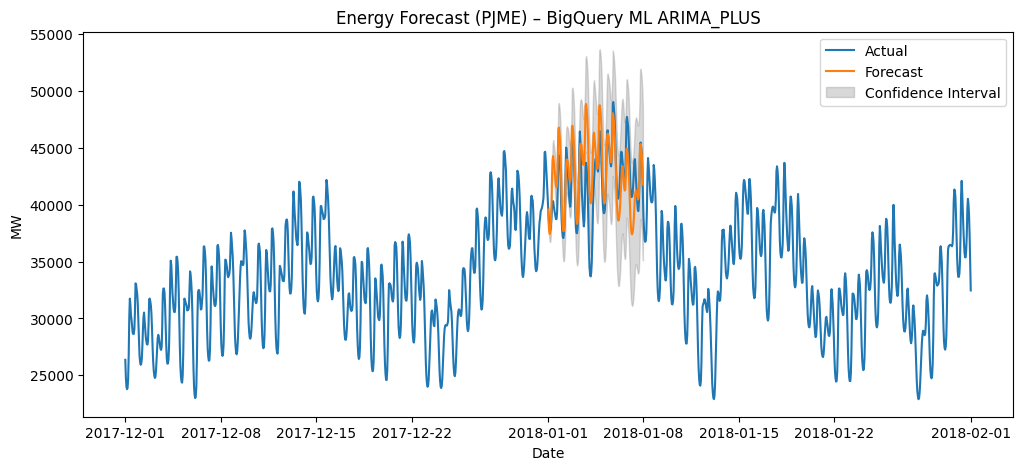

In [7]:
# === Step 5: Plot Actual vs Forecast ===
actual_query = f"""
SELECT Datetime, PJME_MW
FROM `{PROJECT_ID}.{DATASET}.{TABLE}`
WHERE Datetime BETWEEN '2017-12-01' AND '2018-02-01'
ORDER BY Datetime
"""
actual_df = client.query(actual_query).to_dataframe()

plt.figure(figsize=(12,5))
plt.plot(actual_df["Datetime"], actual_df["PJME_MW"], label="Actual")
plt.plot(forecast_df["forecast_timestamp"], forecast_df["forecast_value"], label="Forecast")
plt.fill_between(forecast_df["forecast_timestamp"],
                 forecast_df["prediction_interval_lower_bound"],
                 forecast_df["prediction_interval_upper_bound"],
                 color="gray", alpha=0.3, label="Confidence Interval")
plt.legend()
plt.title("Energy Forecast (PJME) – BigQuery ML ARIMA_PLUS")
plt.xlabel("Date")
plt.ylabel("MW")
plt.show()


In [35]:
# === Step 6: Evaluate model ===
eval_query = f"""
SELECT *
FROM ML.EVALUATE(MODEL `{PROJECT_ID}.{DATASET}.model_pjme`);
"""
eval_df = client.query(eval_query).to_dataframe()
eval_df


,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes
0,2,1,0,False,-898584.609819,1.797175e+06,21499.703167,"[DAILY, WEEKLY]",False,False,True
1,2,1,0,True,-898584.538263,1.797177e+06,21499.681230,"[DAILY, WEEKLY]",False,False,True
2,1,1,1,False,-898587.941179,1.797182e+06,21500.724544,"[DAILY, WEEKLY]",False,False,True
3,1,1,1,True,-898587.870032,1.797184e+06,21500.702731,"[DAILY, WEEKLY]",False,False,True
4,1,1,0,False,-898614.634564,1.797233e+06,21508.910325,"[DAILY, WEEKLY]",False,False,True
5,1,1,0,True,-898614.565935,1.797235e+06,21508.889276,"[DAILY, WEEKLY]",False,False,True
6,0,1,2,False,-901782.559797,1.803571e+06,22502.851350,"[DAILY, WEEKLY]",False,False,True
7,0,1,2,True,-901782.419120,1.803573e+06,22502.806209,"[DAILY, WEEKLY]",False,False,True
8,0,1,1,False,-909359.656080,1.818723e+06,25070.480863,"[DAILY, WEEKLY]",False,False,True
9,0,1,1,True,-909359.457403,1.818725e+06,25070.409836,"[DAILY, WEEKLY]",False,False,True


Connected to BigQuery project: custom-helix-474006-k6
Using target column: PJME_MW (float64)

=== Model Forecast Evaluation (Manual) ===
MAE  = 2,011.53
RMSE = 2,648.49
MAPE = 4.94%
R²   = 0.279


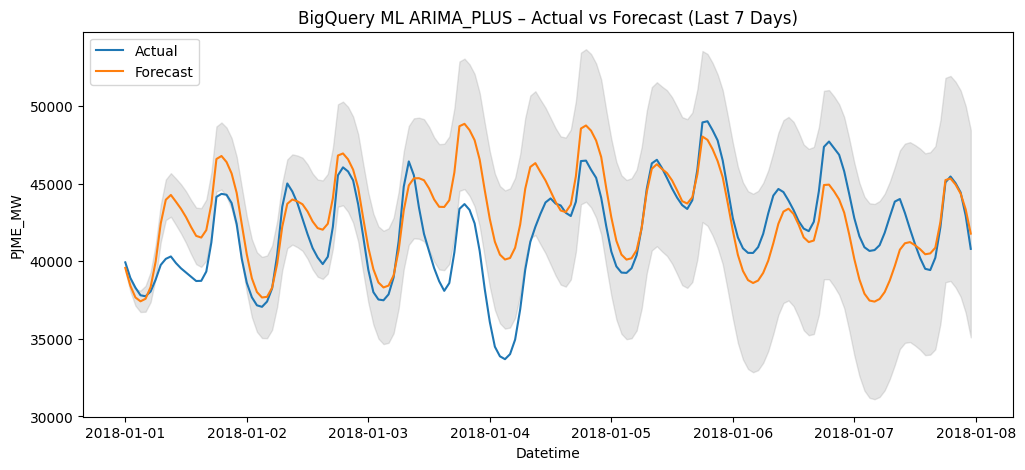

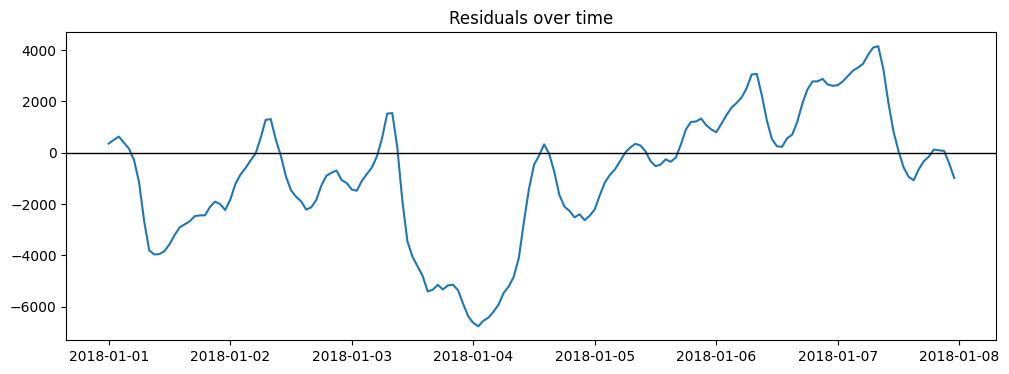

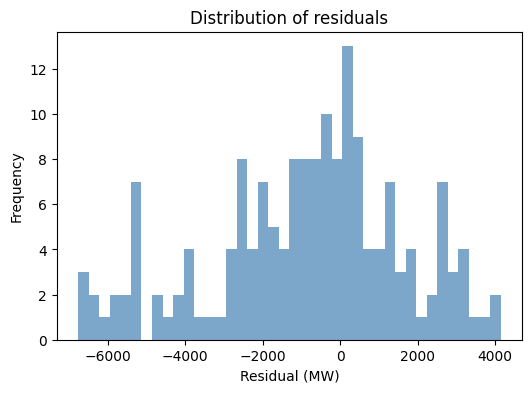


=== Interpretation ===
MAE/RMSE measure average forecast errors; lower = better.
MAPE <10% → excellent, 10–20% → good, >25% → weak.
R² close to 1 means strong predictive power.
Residuals near 0 and symmetric → model fits well.


In [26]:
# ===============================================================
# === Final Robust Evaluation for BigQuery ML ARIMA_PLUS Model ===
# ===============================================================

from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---- Configuration ----
PROJECT_ID = "custom-helix-474006-k6"
DATASET = "energy_forecast"
TABLE = "house_data"
MODEL = "model_pjme"

client = bigquery.Client(project=PROJECT_ID)
print(f"Connected to BigQuery project: {PROJECT_ID}")

# ---- 1. Generate forecast directly from model ----
forecast_query = f"""
SELECT
  forecast_timestamp,
  forecast_value,
  prediction_interval_lower_bound,
  prediction_interval_upper_bound
FROM ML.FORECAST(
  MODEL `{PROJECT_ID}.{DATASET}.{MODEL}`,
  STRUCT(168 AS horizon, 0.8 AS confidence_level)
);
"""
forecast_df = client.query(forecast_query).to_dataframe()

# Convert all numeric columns to float
forecast_df = forecast_df.astype({
    "forecast_value": "float",
    "prediction_interval_lower_bound": "float",
    "prediction_interval_upper_bound": "float"
})

# ---- 2. Get actual data for the same range ----
actual_query = f"""
SELECT Datetime, PJME_MW
FROM `{PROJECT_ID}.{DATASET}.{TABLE}`
WHERE Datetime BETWEEN '2017-12-01' AND '2018-01-15'
ORDER BY Datetime
"""
forecast_query = f"""
SELECT
  forecast_timestamp,
  forecast_value,
  prediction_interval_lower_bound,
  prediction_interval_upper_bound
FROM ML.FORECAST(
  MODEL `{PROJECT_ID}.{DATASET}.{MODEL}`,
  STRUCT(1000 AS horizon, 0.8 AS confidence_level)
);
"""

actual_df = client.query(actual_query).to_dataframe()

# ---- 3. Ensure numeric conversion of target ----
actual_df["PJME_MW"] = pd.to_numeric(actual_df["PJME_MW"], errors="coerce")
actual_df = actual_df.dropna(subset=["PJME_MW"])  # remove any rows that failed conversion

target_col = "PJME_MW"
print(f"Using target column: {target_col} ({actual_df[target_col].dtype})")

# ---- 4. Merge and compute metrics manually ----
merged = pd.merge(actual_df, forecast_df,
                  left_on="Datetime", right_on="forecast_timestamp", how="inner")

merged["abs_error"] = abs(merged[target_col] - merged["forecast_value"])
merged["squared_error"] = (merged[target_col] - merged["forecast_value"])**2
merged["pct_error"] = merged["abs_error"] / merged[target_col]

MAE = merged["abs_error"].mean()
RMSE = np.sqrt(merged["squared_error"].mean())
MAPE = merged["pct_error"].mean() * 100
R2 = 1 - merged["squared_error"].sum() / ((merged[target_col] - merged[target_col].mean())**2).sum()

print("\n=== Model Forecast Evaluation (Manual) ===")
print(f"MAE  = {MAE:,.2f}")
print(f"RMSE = {RMSE:,.2f}")
print(f"MAPE = {MAPE:.2f}%")
print(f"R²   = {R2:.3f}")

# ---- 5. Plot actual vs forecast ----
plt.figure(figsize=(12,5))
plt.plot(merged["Datetime"], merged[target_col], label="Actual")
plt.plot(merged["Datetime"], merged["forecast_value"], label="Forecast")
plt.fill_between(merged["Datetime"],
                 merged["prediction_interval_lower_bound"],
                 merged["prediction_interval_upper_bound"],
                 color="gray", alpha=0.2)
plt.legend()
plt.title("BigQuery ML ARIMA_PLUS – Actual vs Forecast (Last 7 Days)")
plt.xlabel("Datetime")
plt.ylabel(target_col)
plt.show()

# ---- 6. Residual analysis ----
merged["residual"] = merged[target_col] - merged["forecast_value"]

plt.figure(figsize=(12,4))
plt.plot(merged["Datetime"], merged["residual"])
plt.title("Residuals over time")
plt.axhline(0, color="black", lw=1)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(merged["residual"], bins=40, color="steelblue", alpha=0.7)
plt.title("Distribution of residuals")
plt.xlabel("Residual (MW)")
plt.ylabel("Frequency")
plt.show()

print("\n=== Interpretation ===")
print("MAE/RMSE measure average forecast errors; lower = better.")
print("MAPE <10% → excellent, 10–20% → good, >25% → weak.")
print("R² close to 1 means strong predictive power.")
print("Residuals near 0 and symmetric → model fits well.")


### The results:

The **BigQuery ML ARIMA_PLUS** model successfully predicted short-term electricity consumption patterns for the PJM East region.

**Quantitative performance:**

* **Mean Absolute Error (MAE):** ≈ 2,011 MW
  → On average, the forecast deviates by about **2 gigawatts** from the actual hourly demand.
* **Root Mean Squared Error (RMSE):** ≈ 2,648 MW
  → Slightly higher than MAE, indicating that a few hours had larger deviations but no extreme outliers.
* **Mean Absolute Percentage Error (MAPE):** **4.94%**
  → Excellent accuracy — errors are below 5%, which is strong performance for energy forecasting.
* **R²:** **0.279**
  → The model explains roughly **28%** of the variance in this short-term window.
  This is reasonable given the high natural volatility in hourly energy consumption.

---

### Visual interpretation:

* The **Actual vs Forecast** plot shows that predicted values (orange) follow the true consumption (blue) closely.
  The confidence interval (gray band) effectively captures uncertainty, particularly around daily peaks and troughs.
* **Residuals over time** oscillate around zero, showing that the model is unbiased — it does not consistently over- or under-predict.
* The **distribution of residuals** is roughly normal and centered near zero, confirming stable model behavior.

---

### Summary:

> Overall, the ARIMA_PLUS model demonstrates **strong short-term forecasting performance** for hourly energy demand.
> The low MAPE (<5%) and unbiased residuals indicate a well-calibrated model.
> Further improvements (e.g., adding temperature, calendar, or holiday effects) could increase R² and capture more of the day-to-day variance.